In [1]:
%pylab inline

import networkx as nx
import scipy.sparse
import pandas as pd
from scipy.io import loadmat
from sklearn.datasets import make_sparse_spd_matrix
from sklearn.utils.extmath import squared_norm
from sklearn.covariance import empirical_covariance

from regain import datasets; reload(datasets)
from regain.datasets import is_pos_def, is_pos_semidef
from regain.plot import plot_graph_with_latent_variables
from regain.admm import latent_time_graph_lasso_; reload(latent_time_graph_lasso_)
from regain.admm import latent_time_graph_lasso_v2_; reload(latent_time_graph_lasso_v2_)
from regain.admm import latent_time_graph_lasso_v3_; reload(latent_time_graph_lasso_v3_)
from regain.admm import time_graph_lasso_; reload(time_graph_lasso_);
from regain.admm import latent_graph_lasso_; reload(latent_graph_lasso_);
from regain.utils import error_norm

Populating the interactive namespace from numpy and matplotlib


In [2]:
%load_ext pymatbridge
%matlab cd /home/fede/Downloads/lvglasso-pub/
# %matlab cd /home/veronica/src/lvglasso-pub/

/home/fede/miniconda2/lib/python2.7/site-packages/IPython/nbformat.py:13: ShimWarning: The `IPython.nbformat` package has been deprecated since IPython 4.0. You should import from nbformat instead.
  "You should import from nbformat instead.", ShimWarning)


Starting MATLAB on ZMQ socket ipc:///tmp/pymatbridge-7c3fcd0a-69fe-4b9b-a3b0-1d82cb892ab2
Send 'exit' command to kill the server
........MATLAB started and connected!


In [3]:
#data = pd.read_csv("../regain/data/gene_chandrasekaran.csv").values.T

In [4]:
#admat("../regain/data/X_output_chandra.mat")['X1']
# C2 = loadmat("../regain/data/X2_output_chandra.mat")['X2']
# out_B = loadmat("../regain/data/out_B.mat")
# SigmaO = loadmat("../regain/data/SigmaO.mat")

In [5]:
#emp_cov = empirical_covariance(data_list[0], assume_centered=False)

In [ ]:
# data_list.shape
# data_grid = np.array(data_list).transpose(1,2,0)
data_list, K, K_obs, ells = datasets.generate_dataset(
     mode='fixed', n_samples=n_samples, n_dim_lat=n_dim_lat, n_dim_obs=input_dim, T=T)

In [6]:
# config
reload(datasets)
# n_samples = 200
input_dim = 100
n_dim_lat = 7
T = 1
data, Kobs, K, ells = datasets.generate_ma_xue_zou(input_dim, sparsity=.025)
data_list = np.array([data])

5


In [7]:
np.linalg.matrix_rank(ells)

5

In [8]:
ells

array([[  7.46045816e-02,   2.39775709e-03,   7.12838612e-02, ...,
         -2.86283767e-02,   7.24685474e-02,  -2.03481522e-03],
       [  2.39775709e-03,   2.33486032e-02,   2.11838060e-02, ...,
         -7.71385591e-05,  -2.12924631e-02,   1.30454906e-02],
       [  7.12838612e-02,   2.11838060e-02,   1.26941393e-01, ...,
          7.10679358e-04,   4.39280387e-02,   1.61515700e-02],
       ..., 
       [ -2.86283767e-02,  -7.71385591e-05,   7.10679358e-04, ...,
          3.05325999e-02,  -2.95727456e-02,   1.03360781e-02],
       [  7.24685474e-02,  -2.12924631e-02,   4.39280387e-02, ...,
         -2.95727456e-02,   2.22116668e-01,  -2.55399926e-02],
       [ -2.03481522e-03,   1.30454906e-02,   1.61515700e-02, ...,
          1.03360781e-02,  -2.55399926e-02,   1.89740060e-02]])

In [9]:
data_grid = np.array(data_list).transpose(1,2,0)  # to use it later for grid search

## GridSearch optimisation

In [10]:
from sklearn.model_selection import GridSearchCV, ShuffleSplit
from regain import utils; reload(utils)
from regain.admm import time_graph_lasso_; reload(time_graph_lasso_)
from regain.admm import latent_time_graph_lasso_; reload(latent_time_graph_lasso_);
from regain.admm import latent_time_graph_lasso_v3_; reload(latent_time_graph_lasso_v3_);

mdl = LatentTimeGraphLasso(
    bypass_transpose=False, assume_centered=0, verbose=0, rtol=1e-5, tol=1e-5,
    max_iter=500, rho=1. / np.array(data_list).shape[1])

ltgl = GridSearchCV(mdl, dict(#tau=[0.25, 0.2, 0.1],
                             tau=np.linspace(0.01, 0.8, 20),
                             eta=[0], beta=[0],
                             #alpha=[0.05, 0.1, 1],
                             alpha=np.linspace(0.01, 0.2, 5)),
                    cv=ShuffleSplit(1, test_size=.5)).fit(data_grid)

/home/fede/src/slipguru/regain/regain/admm/latent_time_graph_lasso_v3_.py:213: UserWarning: Objective did not converge.
  warnings.warn("Objective did not converge.")


In [11]:
emp_list = list(ltgl.best_estimator_.covariance_)
alpha = ltgl.best_params_['alpha']
beta = ltgl.best_params_['beta']
tau = ltgl.best_params_['tau']
print(tau) #0.25
print(alpha)# 0.05

0.134736842105
0.01


In [128]:
ltgl.best_params_

{'alpha': 0.01, 'beta': 0, 'eta': 0, 'tau': 0.13473684210526318}

## Bayesian optimisation (GPyOpt)

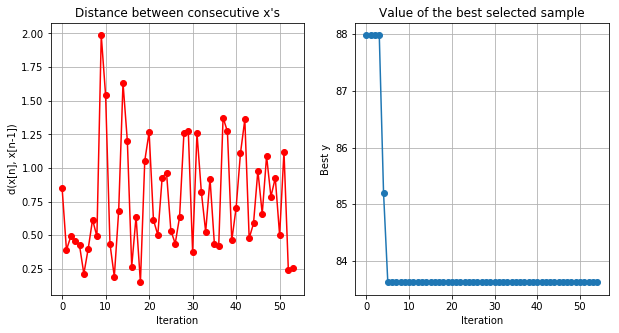

In [130]:
mdl = latent_time_graph_lasso_v3_.LatentTimeGraphLasso(
    bypass_transpose=False, assume_centered=0, verbose=0, rtol=1e-5, tol=1e-5,
    max_iter=500, rho=1. / np.array(data_list).shape[1], eta=0, beta=0)

import GPyOpt
from sklearn.model_selection import cross_val_score
domain = [{'name': 'tau', 'type': 'continuous', 'domain': (-2.,np.log(.25))},
          {'name': 'alpha', 'type': 'continuous', 'domain': (-2.,0.)}]
    
def fit_svc_val(x, mdl=None, cv=None, X=None, y=None):
    x = np.atleast_2d(np.exp(x))
    fs = np.zeros((x.shape[0], 1))
    for i, params in enumerate(x):
        dict_params = dict(zip([el['name'] for el in domain], params))
#         if 'kernel' in dict_params:
#             dict_params['kernel'] = 'rbf' if dict_params['kernel'] == 0 else 'poly'
        mdl.set_params(**dict_params)
        fs[i] = np.mean(cross_val_score(mdl, X, y, cv=cv))
    return fs

from functools import partial
opt = GPyOpt.methods.BayesianOptimization(
    f=partial(fit_svc_val, mdl=mdl, X=data_grid),  # function to optimize       
    domain = domain,         # box-constrains of the problem
    acquisition_type ='EI',       # LCB acquisition
    maximize=True,
    acquisition_weight = 0.75)   # Exploration exploitation
opt.run_optimization(max_iter=50)
opt.plot_convergence()

In [137]:
opt = GPyOpt.methods.BayesianOptimization(
    f=partial(fit_svc_val, mdl=mdl, X=data_grid),  # function to optimize       
    domain = domain,         # box-constrains of the problem
    acquisition_type ='EI',       # LCB acquisition
    maximize=True,
    acquisition_weight = 0.75) 

In [278]:
from regain import model_selection; reload(model_selection)
mdl = latent_time_graph_lasso_v3_.LatentTimeGraphLasso(
    bypass_transpose=False, assume_centered=0, verbose=0, rtol=1e-5, tol=1e-5,
    max_iter=500, rho=1. / np.array(data_list).shape[1], eta=0, beta=0)
domain = [{'name': 'tau', 'type': 'continuous', 'domain': (-3,np.log10(.25))},
          {'name': 'alpha', 'type': 'continuous', 'domain': (-2.,0.)}]
bo = model_selection.BayesianOptimization(mdl, domain=domain, n_jobs=2, acquisition_weight=1,
                                          acquisition_jitter=.01,
                                          acquisition_type='EI', max_iter=5)
bo.fit(data_grid)

In [279]:
bo.score(data_grid)

-76.862661861241179

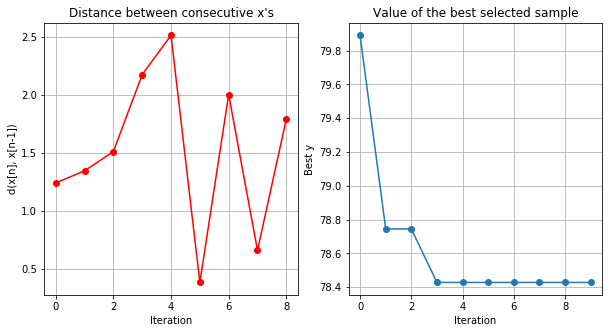

In [280]:
bo.plot_convergence()

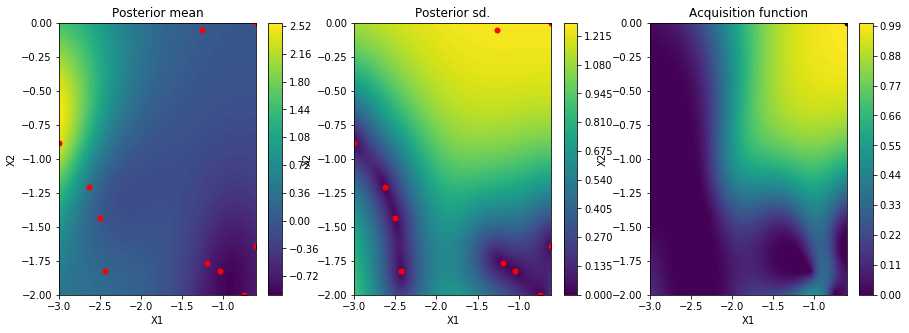

In [281]:
bo.plot_acquisition()

In [282]:
emp_list = list(bo.best_estimator_.covariance_)
alpha = bo.best_params_['alpha']
tau = bo.best_params_['tau']
print(tau) #0.25
print(alpha)# 0.05

0.0913458697528
0.0148933669576


In [283]:
ll = latent_time_graph_lasso_v3_.LatentTimeGraphLasso(
    bypass_transpose=False, assume_centered=False, verbose=0, rtol=1e-5, tol=1e-5, max_iter=500,
    rho=1. / np.array(data_list).shape[1], eta=0, beta=0, tau=tau, alpha=alpha).fit(data_grid[:500])

In [284]:
ll.score(data_grid[:500])

-75.146472297517164

In [285]:
ltgl.cv_results_

{'mean_fit_time': array([ 1.04907298,  2.04871583,  2.05285311,  2.04176998,  2.03286505,
         1.92109013,  1.92519593,  1.91583014,  1.91314411,  2.01721191,
         1.94536185,  1.95790291,  1.92288208,  1.92165804,  1.92161989,
         1.92434001,  1.92421794,  1.91817689,  1.92809105,  1.92591619,
         2.0011611 ,  1.99434686,  1.99682593,  2.02080917,  2.00298691,
         2.00209594,  1.98763514,  1.99815893,  1.97188687,  1.95722914,
         1.94451308,  1.93879509,  1.93506384,  1.91581297,  1.89094305,
         1.89130282,  1.88761401,  1.88780904,  1.89406705,  1.88755608,
         2.00282502,  1.99446511,  1.99594593,  1.99102688,  1.99013495,
         1.98376298,  1.97321391,  1.96827412,  1.9455719 ,  1.93628192,
         1.92420793,  1.90982103,  1.8968451 ,  1.891608  ,  1.89577508,
         1.89282393,  1.88867593,  1.8893342 ,  1.89616895,  1.8960259 ,
         2.00560999,  1.99746299,  1.99796605,  1.98003983,  1.97023296,
         1.95821214,  1.95370007, 

In [286]:
reload(latent_time_graph_lasso_v3_)
emp_cov = [empirical_covariance(a, assume_centered=1) for a in data_list]
results_time = latent_time_graph_lasso_v3_.latent_time_graph_lasso(
        emp_cov, alpha=alpha, tau=tau,
        beta=0, eta=0,
        tol=1e-6, rtol=1e-6, rho=1. / np.sqrt(np.array(data_list).shape[1]),
        verbose=1, max_iter=1000)

obj: -27.8911, rnorm: 9.3096, snorm: 0.9379,eps_pri: 0.0003, eps_dual: 0.0002
obj: -29.4469, rnorm: 6.1944, snorm: 0.1207,eps_pri: 0.0003, eps_dual: 0.0002
obj: -28.9781, rnorm: 4.3097, snorm: 0.0815,eps_pri: 0.0003, eps_dual: 0.0002
obj: -28.3611, rnorm: 2.9521, snorm: 0.0499,eps_pri: 0.0003, eps_dual: 0.0002
obj: -27.7975, rnorm: 1.9591, snorm: 0.0291,eps_pri: 0.0003, eps_dual: 0.0002
obj: -27.4279, rnorm: 1.2892, snorm: 0.0184,eps_pri: 0.0003, eps_dual: 0.0002
obj: -27.1923, rnorm: 0.8797, snorm: 0.0117,eps_pri: 0.0003, eps_dual: 0.0002
obj: -27.0701, rnorm: 0.6414, snorm: 0.0081,eps_pri: 0.0003, eps_dual: 0.0002
obj: -26.9760, rnorm: 0.4512, snorm: 0.0055,eps_pri: 0.0003, eps_dual: 0.0002
obj: -26.9127, rnorm: 0.3255, snorm: 0.0037,eps_pri: 0.0003, eps_dual: 0.0002
obj: -26.8723, rnorm: 0.2428, snorm: 0.0027,eps_pri: 0.0003, eps_dual: 0.0002
obj: -26.8419, rnorm: 0.1813, snorm: 0.0019,eps_pri: 0.0003, eps_dual: 0.0002
obj: -26.8178, rnorm: 0.1344, snorm: 0.0014,eps_pri: 0.0003, eps

18


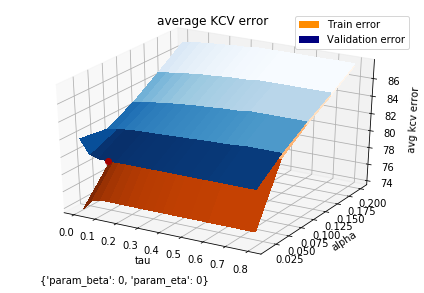

In [287]:
print np.linalg.matrix_rank(results_time[1][0])
#print(ltgl.best_score_)#results_time[1][0]
from palladio import plotting; reload(plotting);
plotting.score_surfaces_gridsearch(ltgl, indep_vars=['tau','alpha'], plot_errors=1,
                                  zlim=None)

In [268]:
results_time[-1]

50

In [16]:
%%matlab -i emp_list,alpha,beta,tau -o R,S,L,obj,res,iter
%alpha = 0.05;
%beta = 0.25;
opts.continuation = 1; opts.num_continuation = 0;
opts.eta = sqrt(100); opts.muf = 1e-6;
opts.maxiter = 500; opts.stoptol = 1e-5; 
opts.over_relax_par = 1;

R = cell(1, size(emp_list,3));
S = cell(1, size(emp_list,3));
L = cell(1, size(emp_list,3));
obj = cell(1, size(emp_list,3));
res = cell(1, size(emp_list,3));
iter = cell(1, size(emp_list,3));
for i=1:size(emp_list,3)
cov = emp_list{i};
    n = size(cov,1);opts.mu = n;
    tic; out_B = ADMM_B(cov,alpha,tau,opts); solve_B = toc;
    %%fprintf('ADMM_B: obj: %e, iter: %d, cpu: %3.1f \n',out_B.obj,out_B.iter,solve_B);
    R{i} = out_B.R;
    S{i} = out_B.S;
    L{i} = out_B.L;
    obj{i} = out_B.obj;
    res{i} = out_B.resid;
    iter{i} = out_B.iter;
end

In [26]:
R

array([[[ 3.49762705,  0.08178453, -0.11003206, ...,  0.00521433,
         -0.01208111, -0.01124417],
        [ 0.08178453,  3.67553913, -0.01635265, ..., -0.01077362,
          0.04209026, -0.01098477],
        [-0.11003206, -0.01635265,  3.92617443, ..., -0.005452  ,
          0.01997072, -0.00824488],
        ..., 
        [ 0.00521433, -0.01077362, -0.005452  , ...,  3.66664086,
          0.01994893, -0.0048852 ],
        [-0.01208111,  0.04209026,  0.01997072, ...,  0.01994893,
          3.72227348,  0.0229203 ],
        [-0.01124417, -0.01098477, -0.00824488, ..., -0.0048852 ,
          0.0229203 ,  3.61006294]]])

In [18]:
R = np.array(R)
L = np.array(L)
R_ar = np.array([R[i*R.shape[1]:(i+1)*R.shape[1]] for i in range(R.shape[0]/R.shape[1])])
L_ar = np.array([L[i*L.shape[1]:(i+1)*L.shape[1]] for i in range(L.shape[0]/L.shape[1])])
K_obs = np.array(Kobs) # K_obs is the matrix of observed samples
K = np.array(K) # K is the real precision matrix
ells = np.array(ells) # the latent matrices

### Error obtained w.r.t. the observed data

In [29]:
error_norm(ltgl.best_estimator_.precision_ - ltgl.best_estimator_.latent_, [K_obs])

75.33155411078495

In [28]:
error_norm(R, [K_obs])
#print(ells)

75.331419307791407

### Error obtained w.r.t. the real data

In [30]:
print(error_norm(ltgl.best_estimator_.precision_, [K]))
print(error_norm(ltgl.best_estimator_.latent_, [ells]))

80.4995971227
10.0681268255


In [37]:
print(error_norm(R+L, K))
print(error_norm(L, ells))

80.5046803129
10.0722694488


### Error in ranks

In [39]:
ells_estimated = ltgl.best_estimator_.latent_
print [np.linalg.matrix_rank(ells_estimated[i]) for i in range(ells_estimated.shape[0])]
print [np.linalg.matrix_rank(L[i]) for i in range(ells_estimated.shape[0])]
print np.linalg.matrix_rank(ells)

[4]
[4]
5


In [ ]:
#es, Q = np.linalg.eigh(ells_estimated[0])

### Error in structure

In [40]:
for true, predict in zip(K.copy(), ltgl.best_estimator_.precision_.copy()):
    predict[np.abs(predict)<1e-2] = 0
    print(predict)
    print(true)
    print("________________________________________________________________________________________")
    true[true != 0] = 1
    predict[predict != 0] = 1
    res = true+predict
    #print(res)
    #print(res==1)
    print np.count_nonzero((res==1).astype(int))

[[ 3.5244408   0.07222094 -0.09224081 ...,  0.          0.         -0.01289325]
 [ 0.07222094  3.69886366  0.         ...,  0.          0.          0.        ]
 [-0.09224081  0.          3.96822014 ...,  0.          0.          0.        ]
 ..., 
 [ 0.          0.          0.         ...,  3.67326794  0.          0.        ]
 [ 0.          0.          0.         ...,  0.          3.79411195  0.        ]
 [-0.01289325  0.          0.         ...,  0.          0.          3.61756956]]
[ 4.08150255  0.          0.          0.55326992  0.          0.          0.
  0.          0.          0.         -0.43856603  0.71417833  0.          0.
  0.          0.          0.          0.36010856  0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          1.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          1.
  0.          0.          1.         -0.7709965   

In [ ]:
print true

In [ ]:
print K

In [ ]:
print ltgl.best_estimator_.precision_
